<a href="https://colab.research.google.com/github/aminayusif/Retentify/blob/main/Retentify_Customer_Retention_And_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook presents the development of **Retentify**, a comprehensive system designed to analyze telco customer churn and provide targeted recommendations for retention and value enhancement. Leveraging data analysis, machine learning, and customer segmentation techniques, Retentify aims to identify customers at risk of churning and suggest personalized interventions.

The system is built in several stages:

1.  **Data Loading and Preprocessing:** Initial loading of the telco customer churn dataset, followed by essential cleaning and preprocessing steps to handle missing values, correct data types, and standardize categorical features.
2.  **Exploratory Data Analysis (EDA):** Conducting univariate and bivariate analysis, correlation analysis, and customer segmentation to gain insights into churn drivers and identify distinct customer groups.
3.  **Feature Engineering:** Creating new features from the raw data to improve the performance of predictive models and enhance the understanding of customer behavior.
4.  **Churn Prediction Model Development:** Building and evaluating machine learning models (Logistic Regression, Random Forest, XGBoost) to predict customer churn probability, including addressing class imbalance and hyperparameter tuning.
5.  **Model Explainability and Rule Extraction:** Analyzing the trained churn model to understand the key factors influencing churn predictions using techniques like feature importance and SHAP values, and translating these insights into actionable business rules.
6.  **Customer Segmentation:** Applying clustering techniques to group customers into distinct segments based on their characteristics and behavior.
7.  **Recommendation System Design:** Developing a hybrid recommendation system that combines rule-based recommendations (derived from EDA and model explainability) and collaborative filtering (using matrix factorization) to provide personalized suggestions.
8.  **API Development:** Creating a web API using FastAPI to serve the churn predictions and recommendations.

Retentify provides a data-driven approach to proactively manage customer churn, allowing telco companies to implement targeted strategies to retain valuable customers and optimize their service offerings.

#### Data Loading and Preprocessing

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Quick integrity checks
df.head()
df.info()
df.describe()
df.isna().sum()

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Check data types
print("\nData types:\n", df.dtypes)

# Check for unexpected types (specifically TotalCharges)
print("\nUnique values in TotalCharges:\n", df['TotalCharges'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Fix data types

In [2]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill NaN values resulting from the conversion (empty strings) with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Check data types again to confirm the change
print("\nData types after converting TotalCharges:\n", df.dtypes)

# Convert the 'SeniorCitizen' column to boolean
df['SeniorCitizen'] = df['SeniorCitizen'].astype(bool)

# Check unique values for object type columns (excluding customerID)
for col in df.select_dtypes(include='object').columns:
    if col != 'customerID':
        print(f"\nUnique values in {col}:\n{df[col].unique()}")


Data types after converting TotalCharges:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Unique values in gender:
['Female' 'Male']

Unique values in Partner:
['Yes' 'No']

Unique values in Dependents:
['No' 'Yes']

Unique values in PhoneService:
['No' 'Yes']

Unique values in MultipleLines:
['No phone service' 'No' 'Yes']

Unique values in InternetService:
['DSL' 'Fiber optic' 'No']

Unique values in OnlineSecurity:
['No' 'Yes' 'No inter

#### Handle missing values

In [3]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


#### Standardize categorical features

In [4]:
# Identify object columns to standardize (excluding customerID)
cols_to_standardize = [col for col in df.select_dtypes(include='object').columns if col != 'customerID']

# Iterate through the identified columns and standardize values
for col in cols_to_standardize:
    if 'No internet service' in df[col].unique() or 'No phone service' in df[col].unique():
        print(f"Standardizing column: {col}")
        df[col] = df[col].replace(['No internet service', 'No phone service'], 'No')

# Verify the changes by printing unique values of the modified columns
for col in cols_to_standardize:
    if 'No internet service' not in df[col].unique() and 'No phone service' not in df[col].unique():
        print(f"\nUnique values in {col} after standardization:\n{df[col].unique()}")

Standardizing column: MultipleLines
Standardizing column: OnlineSecurity
Standardizing column: OnlineBackup
Standardizing column: DeviceProtection
Standardizing column: TechSupport
Standardizing column: StreamingTV
Standardizing column: StreamingMovies

Unique values in gender after standardization:
['Female' 'Male']

Unique values in Partner after standardization:
['Yes' 'No']

Unique values in Dependents after standardization:
['No' 'Yes']

Unique values in PhoneService after standardization:
['No' 'Yes']

Unique values in MultipleLines after standardization:
['No' 'Yes']

Unique values in InternetService after standardization:
['DSL' 'Fiber optic' 'No']

Unique values in OnlineSecurity after standardization:
['No' 'Yes']

Unique values in OnlineBackup after standardization:
['Yes' 'No']

Unique values in DeviceProtection after standardization:
['No' 'Yes']

Unique values in TechSupport after standardization:
['No' 'Yes']

Unique values in StreamingTV after standardization:
['No' 'Ye

#### Create target variable



Map 'Yes'/'No' in the 'Churn' column to 1/0.

In [5]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print("\nValue counts after mapping 'Churn':\n", df['Churn'].value_counts())


Value counts after mapping 'Churn':
 Churn
0    5174
1    1869
Name: count, dtype: int64


### Exploratory Data Analysis

#### Univariate analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical and categorical columns, excluding 'customerID'
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


Generate histograms and count plots for  the various identified numerical columns to visualize their distributions.

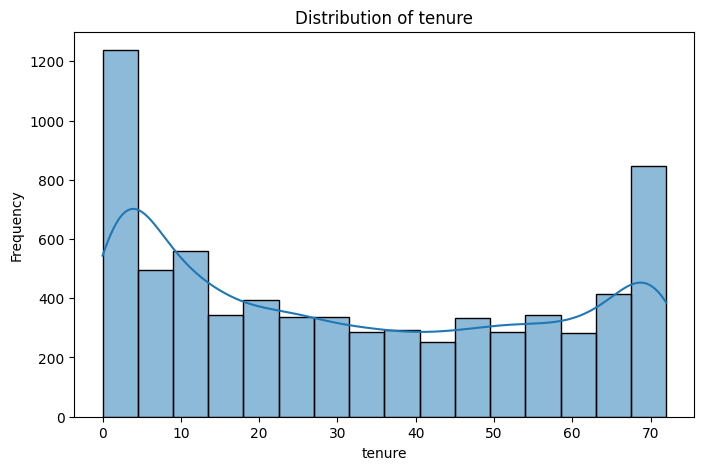

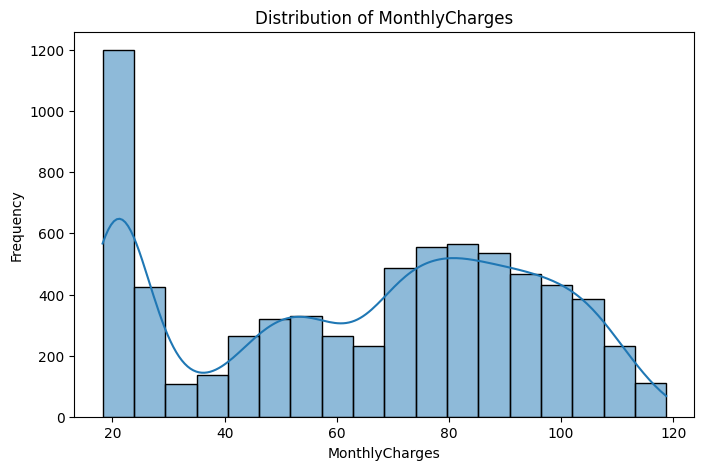

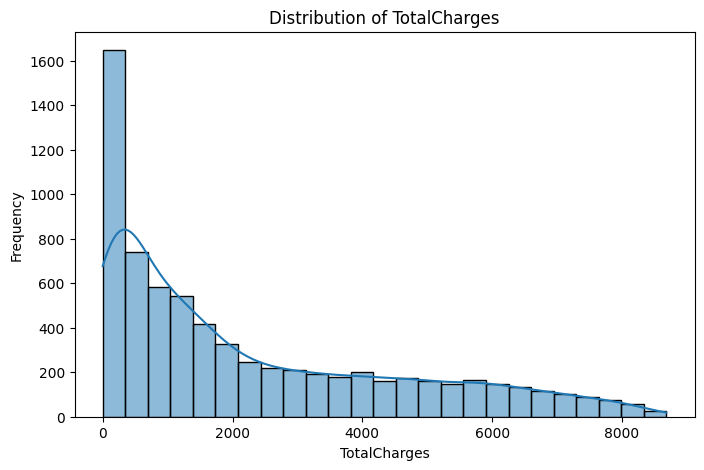

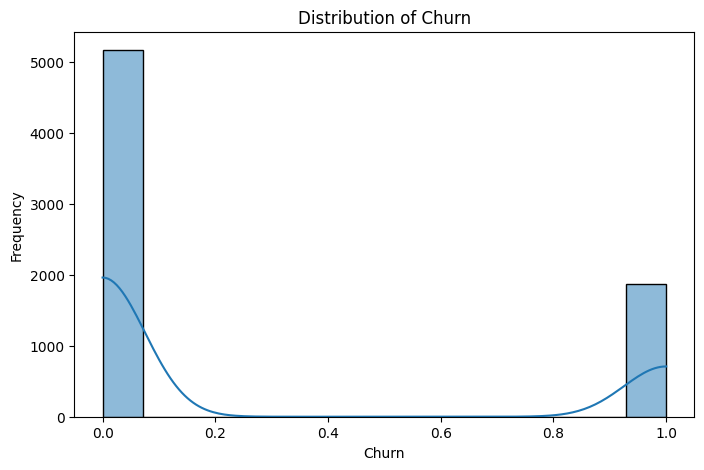

In [7]:
# Generate histograms for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

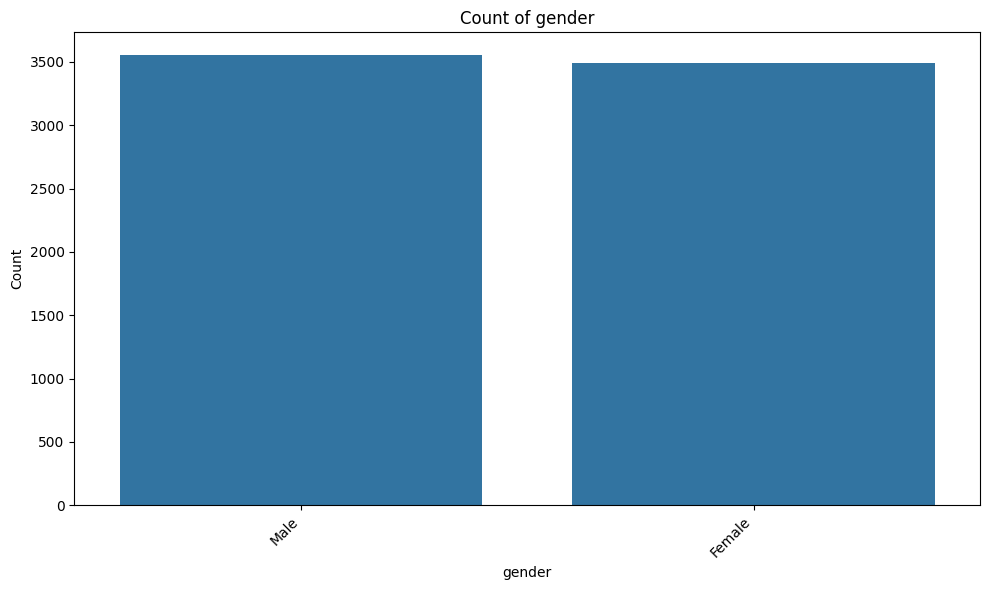

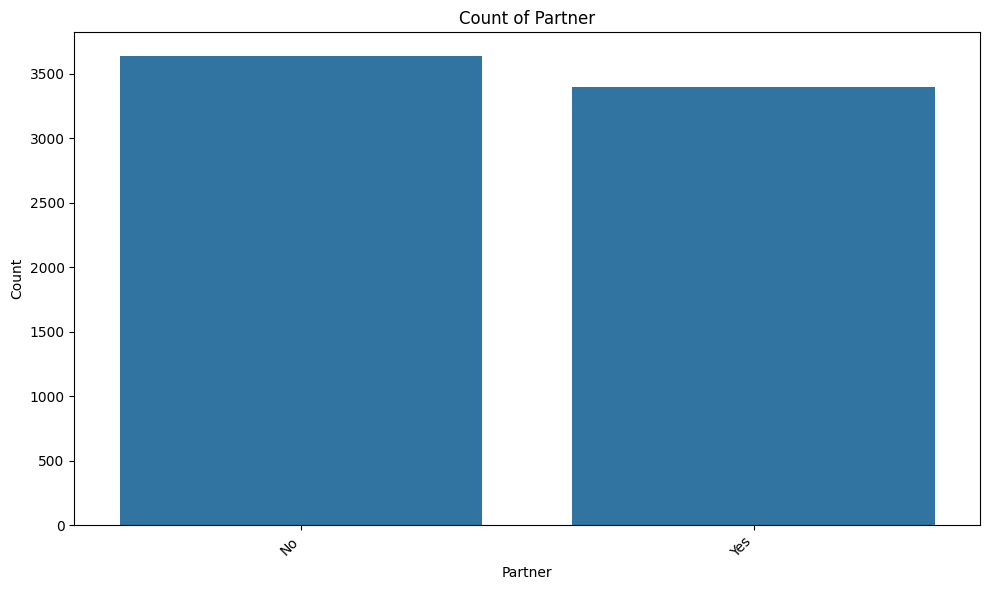

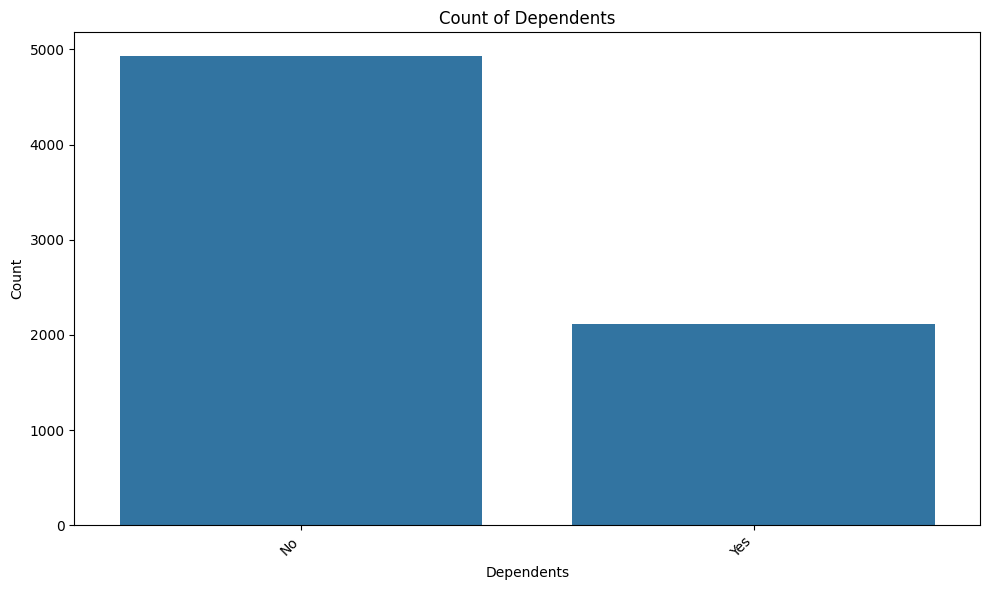

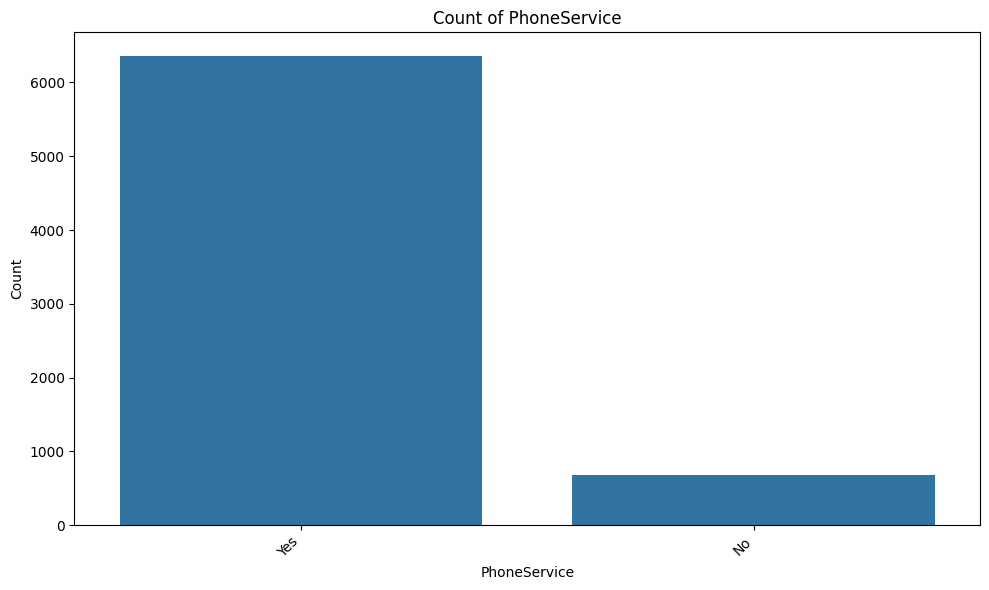

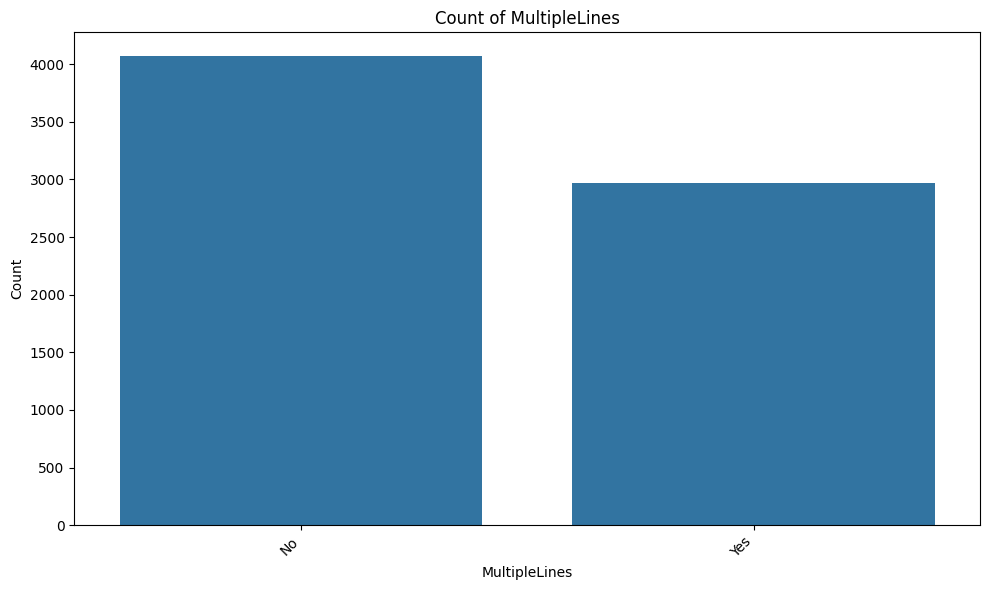

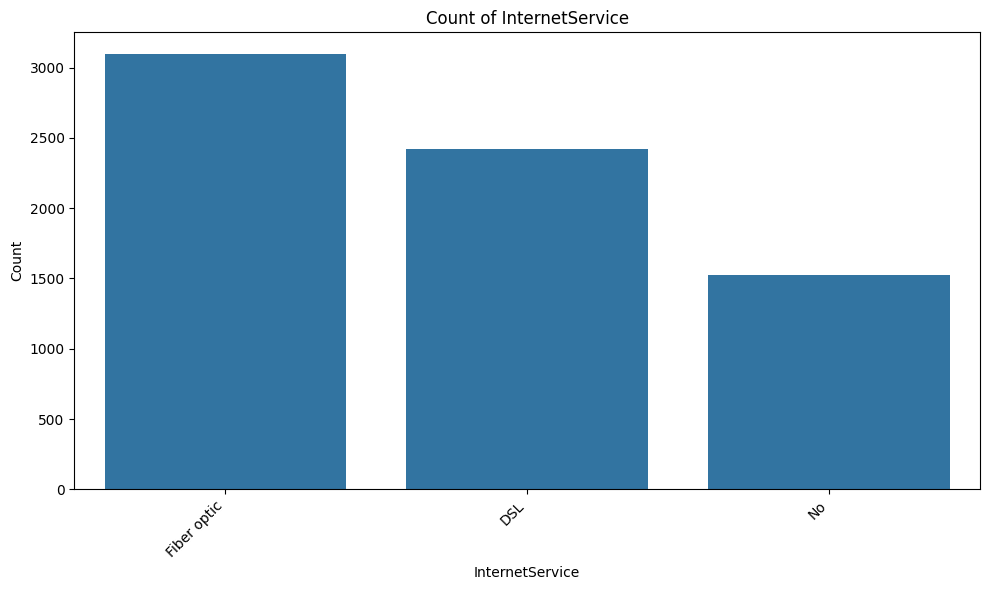

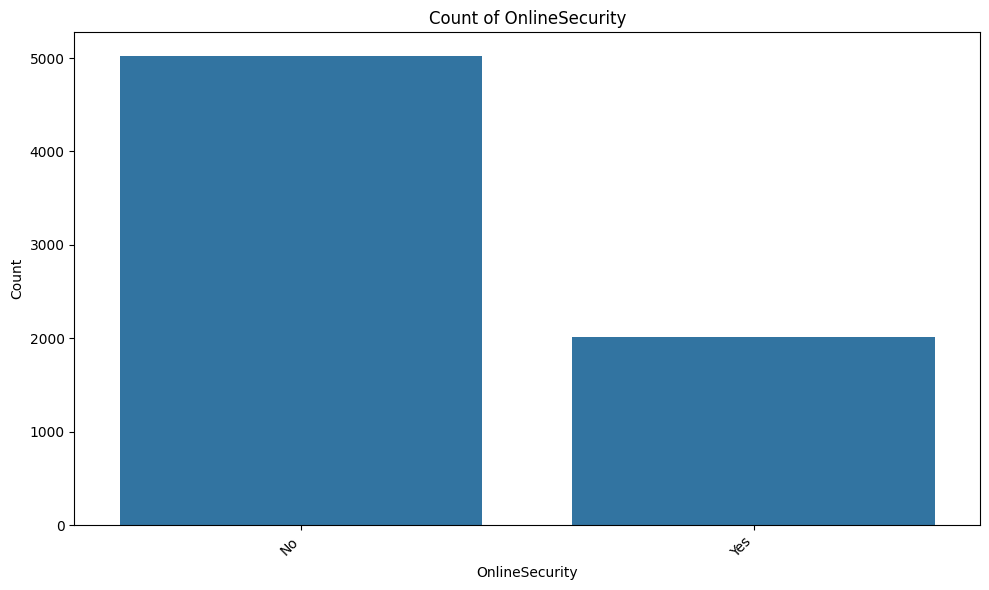

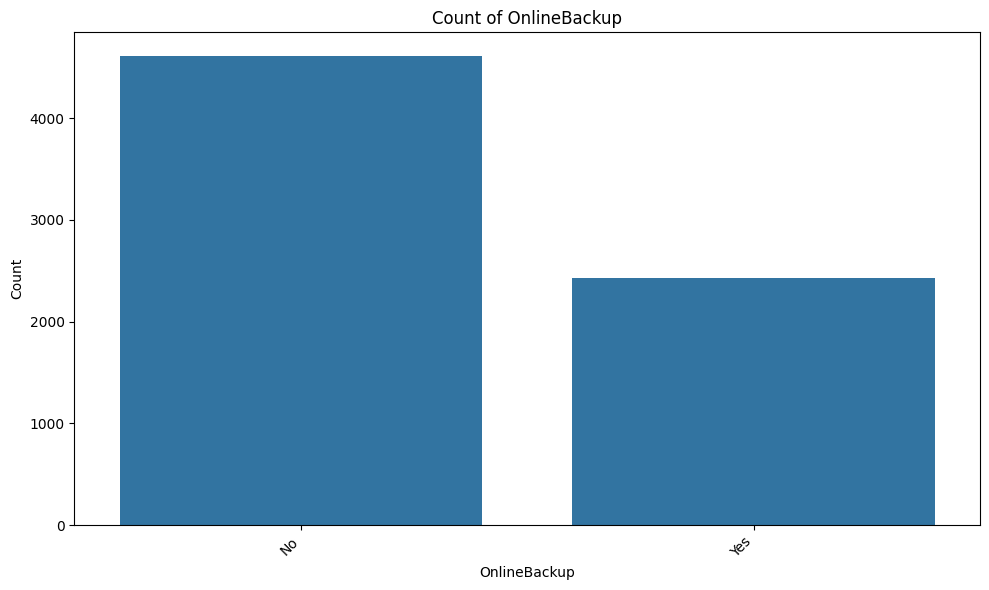

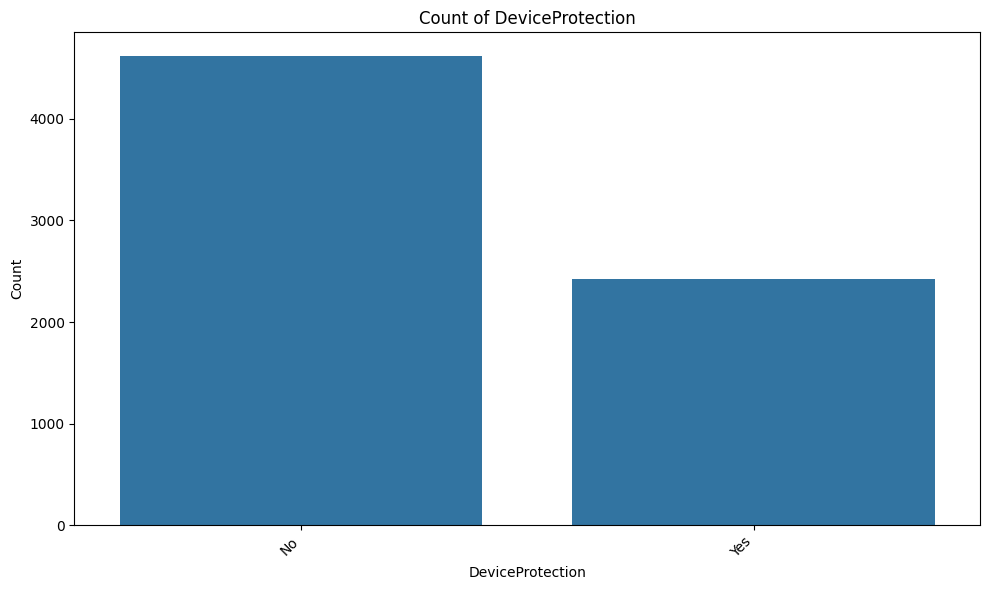

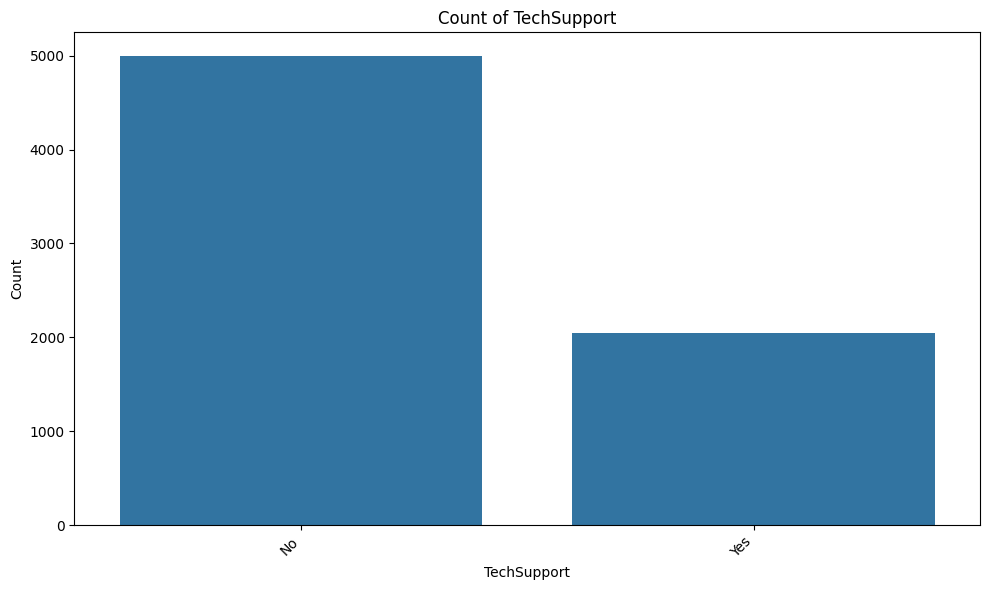

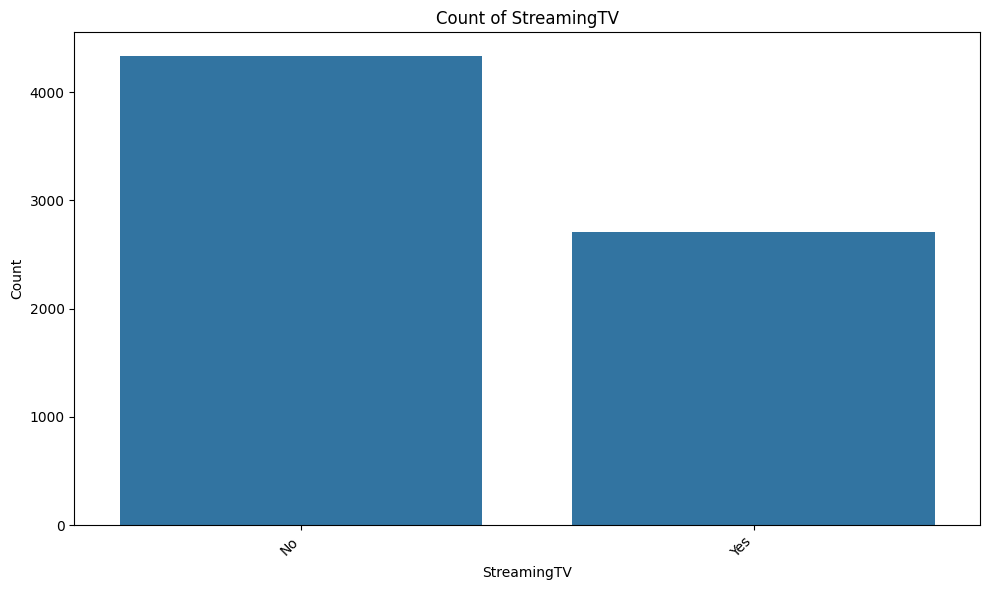

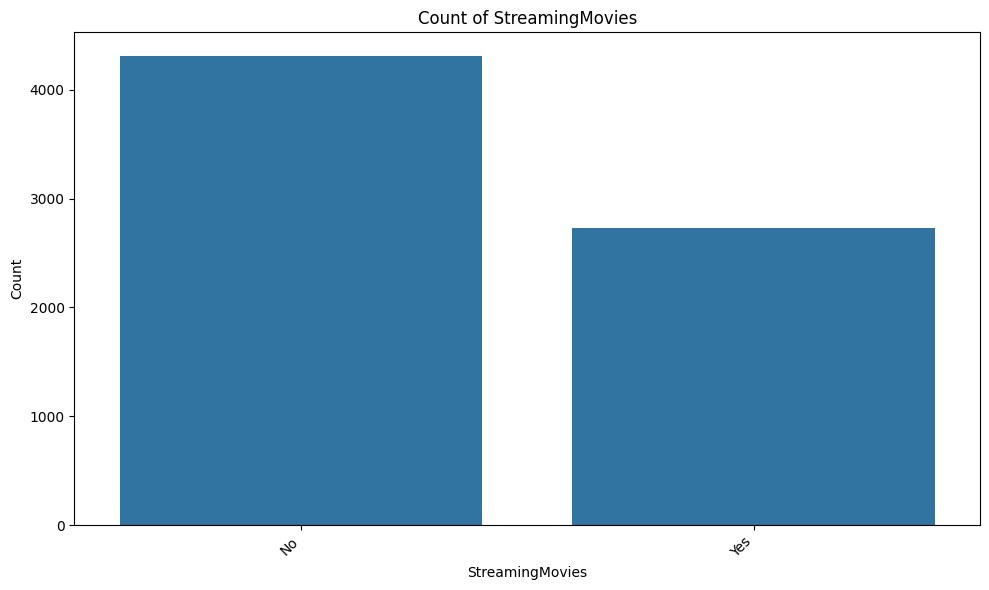

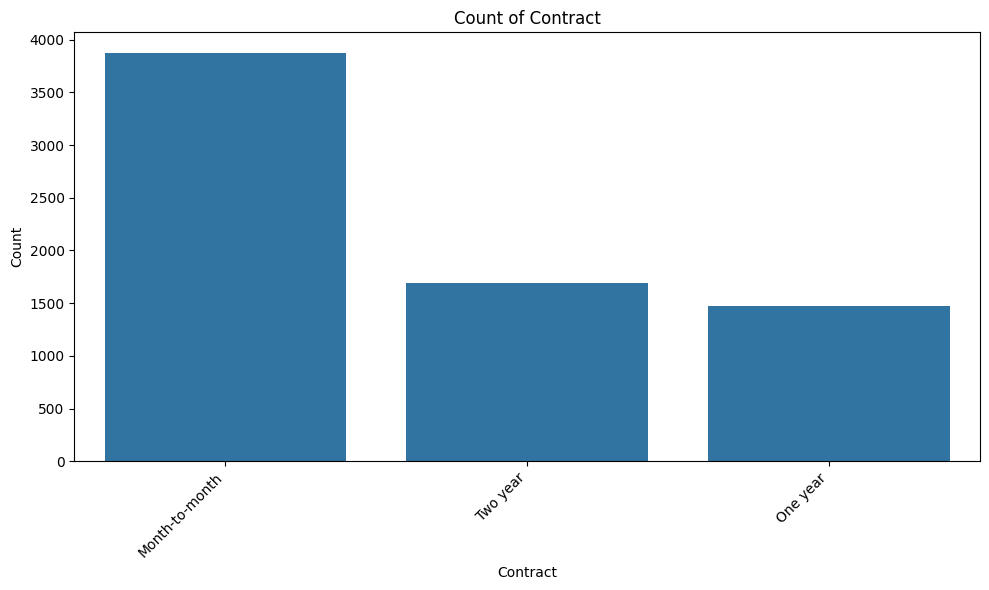

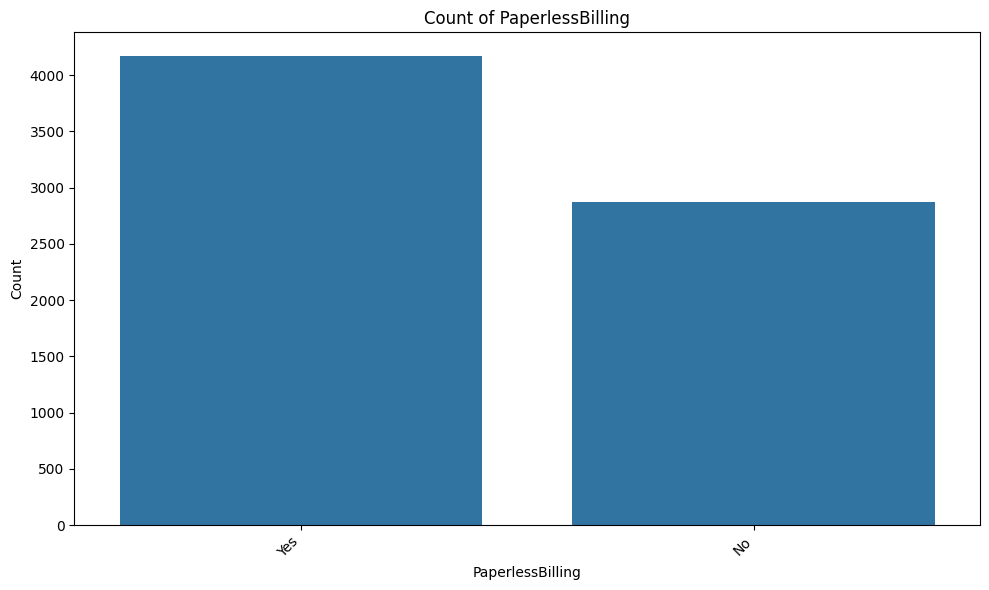

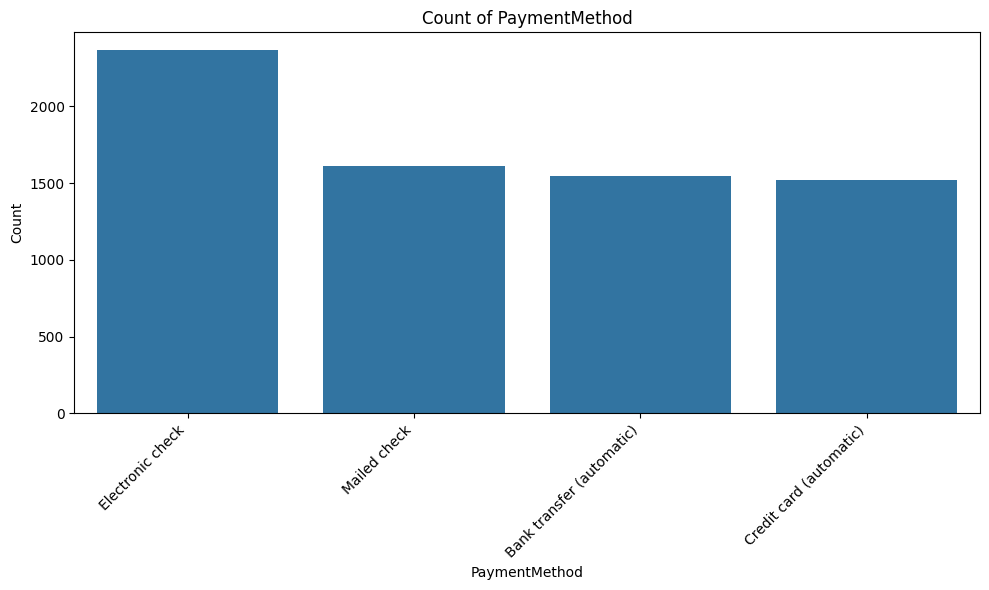

In [8]:
# Generate count plots for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Bivariate analysis

Analyze churn rate across different categories.

Iterate through categorical columns, create cross-tabulations with 'Churn', calculate churn rates, and print them.

In [9]:
# Get categorical columns excluding 'customerID'
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

# Analyze churn rate across different categorical columns
for col in categorical_cols:
    print(f"\nChurn rate by {col}:")
    # Create a cross-tabulation
    churn_crosstab = pd.crosstab(df[col], df['Churn'])
    # Calculate churn rate for each category
    churn_rate = churn_crosstab[1] / churn_crosstab.sum(axis=1)
    print(churn_rate)


Churn rate by gender:
gender
Female    0.269209
Male      0.261603
dtype: float64

Churn rate by Partner:
Partner
No     0.329580
Yes    0.196649
dtype: float64

Churn rate by Dependents:
Dependents
No     0.312791
Yes    0.154502
dtype: float64

Churn rate by PhoneService:
PhoneService
No     0.249267
Yes    0.267096
dtype: float64

Churn rate by MultipleLines:
MultipleLines
No     0.250246
Yes    0.286099
dtype: float64

Churn rate by InternetService:
InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
dtype: float64

Churn rate by OnlineSecurity:
OnlineSecurity
No     0.313296
Yes    0.146112
dtype: float64

Churn rate by OnlineBackup:
OnlineBackup
No     0.291721
Yes    0.215315
dtype: float64

Churn rate by DeviceProtection:
DeviceProtection
No     0.286518
Yes    0.225021
dtype: float64

Churn rate by TechSupport:
TechSupport
No     0.311862
Yes    0.151663
dtype: float64

Churn rate by StreamingTV:
StreamingTV
No     0.243312
Yes    0.300702


#### Correlation Matrix

Select the numerical columns and compute the correlation matrix, then create and display the heatmap.



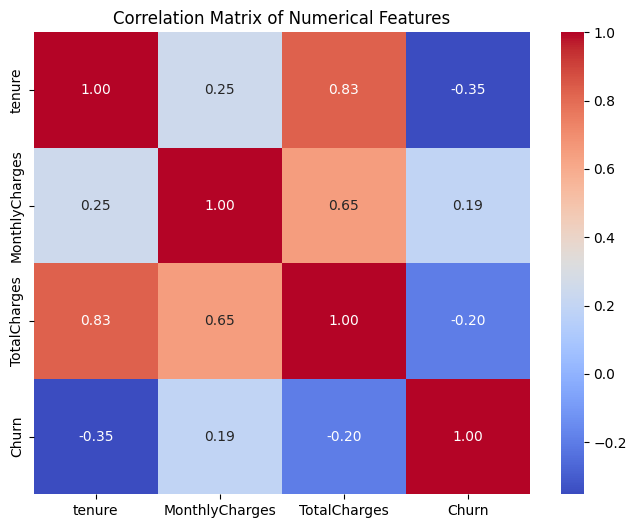

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
numerical_df = df[numerical_cols]

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Based on the correlation matrix we  generated, here's a specific interpretation of the relationships between the numerical features:

**Tenure and TotalCharges (0.83)**: There is a strong positive correlation between tenure and TotalCharges. This is expected, as customers who stay with the service longer (tenure) will naturally accumulate higher total charges (TotalCharges).

**MonthlyCharges and TotalCharges (0.65)**: There is a moderately strong positive correlation between MonthlyCharges and TotalCharges. This also makes sense, as higher monthly charges contribute to higher total charges, although not as strongly as tenure.

**Tenure and Churn (-0.35)**: There is a moderate negative correlation between tenure and Churn. This indicates that customers who have been with the service for a longer period are less likely to churn.

**MonthlyCharges and Churn (0.19)**: There is a weak positive correlation between MonthlyCharges and Churn. This suggests that customers with higher monthly charges are slightly more likely to churn.

**TotalCharges and Churn (-0.20)**: There is a weak negative correlation between TotalCharges and Churn. This suggests that customers with higher total charges are slightly less likely to churn, which aligns with the stronger negative correlation between tenure and churn.

In summary, the correlation matrix highlights that tenure is the numerical feature with the strongest relationship to Churn, indicating that longer-term customers are less likely to leave. MonthlyCharges and TotalCharges have weaker correlations with churn, and their relationships are more influenced by tenure.

#### Segment Analysis

The essence of segment analysis in this project is to group customers into distinct categories based on their characteristics and behavior. By identifying these segments, we can gain a deeper understanding of the different types of customers we have, their varying needs, and importantly, how their likelihood to churn differs across these groups.

This allows us to:



*   Identify high-risk segments: Pinpoint
which customer groups are most likely to churn, enabling targeted retention efforts.

*  Tailor recommendations: Develop personalized recommendations and strategies for each segment, addressing their specific needs and preferences.

*  Optimize marketing and service: Design more effective marketing campaigns and improve service offerings by understanding what resonates with each segment.

In short, segment analysis moves beyond looking at the overall customer base and helps us see the diverse landscape of our customers, allowing for more precise and effective action

Generate a scatter plot to visualize the relationship between MonthlyCharges, tenure, and Churn.

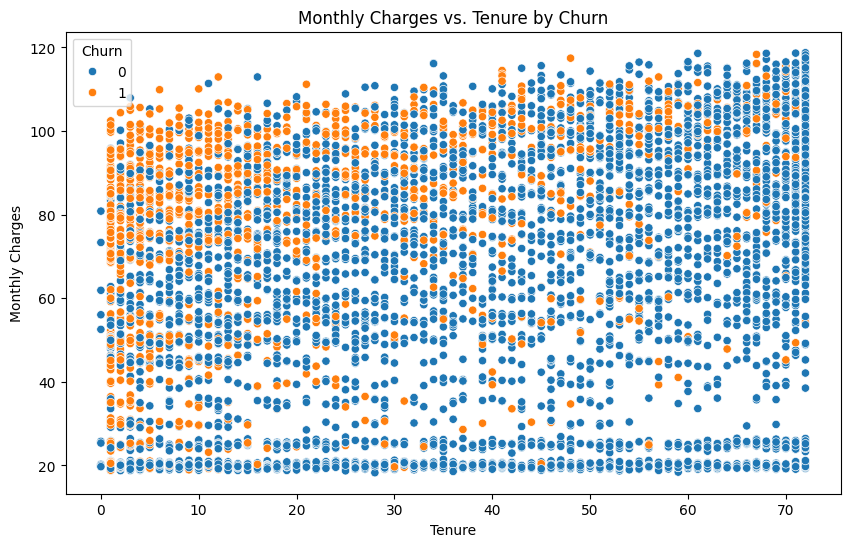

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn')
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges vs. Tenure by Churn')
plt.legend(title='Churn')
plt.show()

Looking at the scatter plot of Monthly Charges vs. Tenure by Churn, here's a specific interpretation:

**Churned Customers (Orange dots):**
There is a higher concentration of churned customers among those with low tenure (customers who have been with the service for a short period).

Churned customers are spread across various monthly charges, but there seems to be a notable cluster of churned customers with high monthly charges and low to medium tenure. This suggests that newer customers with high bills are more likely to leave.

**Non-Churned Customers (Blue dots):**

Non-churned customers are more prevalent among those with high tenure (long-term customers).
These customers are also spread across different monthly charges, but there's a strong presence of non-churned customers with high tenure
regardless of their monthly charges.
In summary, the scatter plot visually reinforces the findings from the correlation matrix: customers with shorter tenures are more likely to churn, and this is particularly true for those with higher monthly charges.

Long-term customers, regardless of their monthly charges, are less likely to churn. This plot helps to visually identify these segments at risk of churn.

#### Document Insights

Extract and document clear rules/insights from the EDA for a rule-based recommender based on the bivariate analysis, correlation matrix, and segment analysis visualization.

In [12]:
# Document insights for a rule-based recommender based on EDA findings

print("Insights and Rules for a Rule-Based Recommender:")
print("-" * 50)

print("\nKey Factors Associated with High Churn:")
print("- **Contract Type:** Month-to-month contracts have a significantly higher churn rate (42.7%).")
print("- **Internet Service:** Customers with Fiber optic internet service show a high churn rate (41.9%).")
print("- **Payment Method:** Electronic check users have the highest churn rate (45.3%).")
print("- **Online Security & Tech Support:** Absence of these services is linked to higher churn (around 31%).")
print("- **Partner & Dependents:** Customers without partners or dependents tend to churn more (around 31-33%).")
print("- **Paperless Billing:** Customers with paperless billing have a higher churn rate (33.6%).")

print("\nCorrelation Analysis Insights:")
print("- **Tenure:** Has a strong negative correlation with Churn (-0.35), indicating that longer-term customers are less likely to churn.")
print("- **Monthly Charges:** Has a positive correlation with Churn (0.19), suggesting that customers with higher monthly charges are slightly more likely to churn.")
print("- **Total Charges:** Has a negative correlation with Churn (-0.20), but this is likely influenced by tenure (longer tenure leads to higher total charges and lower churn).")

print("\nSegment Analysis Insights (Monthly Charges vs. Tenure by Churn):")
print("- Customers with low tenure (new customers) across all ranges of Monthly Charges show a higher propensity to churn.")
print("- Customers with high Monthly Charges, even with moderate tenure, appear to have a higher churn rate compared to those with lower Monthly Charges at the same tenure.")
print("- Long-tenure customers (generally > 40-50 months) across various Monthly Charge levels have a lower churn rate, reinforcing the tenure correlation.")

print("\nPotential Rules for Recommender:")
print("- **Rule 1:** Recommend contract changes (e.g., to one or two-year contracts) for customers on month-to-month plans.")
print("- **Rule 2:** For customers with Fiber optic service and high monthly charges, consider targeted offers or support to improve retention.")
print("- **Rule 3:** Encourage customers using Electronic check to switch to automatic payment methods (Bank transfer or Credit card).")
print("- **Rule 4:** Promote Online Security and Tech Support services to customers who currently do not have them.")
print("- **Rule 5:** Develop specific engagement strategies for new customers (low tenure) to build loyalty early on.")
print("- **Rule 6:** Customers with high Monthly Charges and low/moderate tenure should be considered a high-risk segment for targeted retention efforts.")

print("-" * 50)

Insights and Rules for a Rule-Based Recommender:
--------------------------------------------------

Key Factors Associated with High Churn:
- **Contract Type:** Month-to-month contracts have a significantly higher churn rate (42.7%).
- **Internet Service:** Customers with Fiber optic internet service show a high churn rate (41.9%).
- **Payment Method:** Electronic check users have the highest churn rate (45.3%).
- **Online Security & Tech Support:** Absence of these services is linked to higher churn (around 31%).
- **Partner & Dependents:** Customers without partners or dependents tend to churn more (around 31-33%).
- **Paperless Billing:** Customers with paperless billing have a higher churn rate (33.6%).

Correlation Analysis Insights:
- **Tenure:** Has a strong negative correlation with Churn (-0.35), indicating that longer-term customers are less likely to churn.
- **Monthly Charges:** Has a positive correlation with Churn (0.19), suggesting that customers with higher monthly cha